In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
import healpy as hp
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_43129/940257387.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

## Quasars

In [64]:
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

pd_qsrs = pd.read_csv("../data/quasars_phot.csv")

pmra_err = pd_qsrs['pmra_error'].values
pmdec_err = pd_qsrs['pmdec_error'].values

ra = pd_qsrs['ra'].values
dec = pd_qsrs['dec'].values

coords_qsrs_icrs = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
coords_qsrs = coords_qsrs_icrs.transform_to('galactic')

n_qsrs = len(pd_qsrs)

  0%|          | 0/43382 [00:00<?, ?it/s]

  0%|          | 0/43382 [00:00<?, ?it/s]

/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_43129/1248211287.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(pmdec_err_map / np.sqrt(n_qsrs_map))
/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_43129/1248211287.py:2: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(pmra_err_map / np.sqrt(n_qsrs_map))


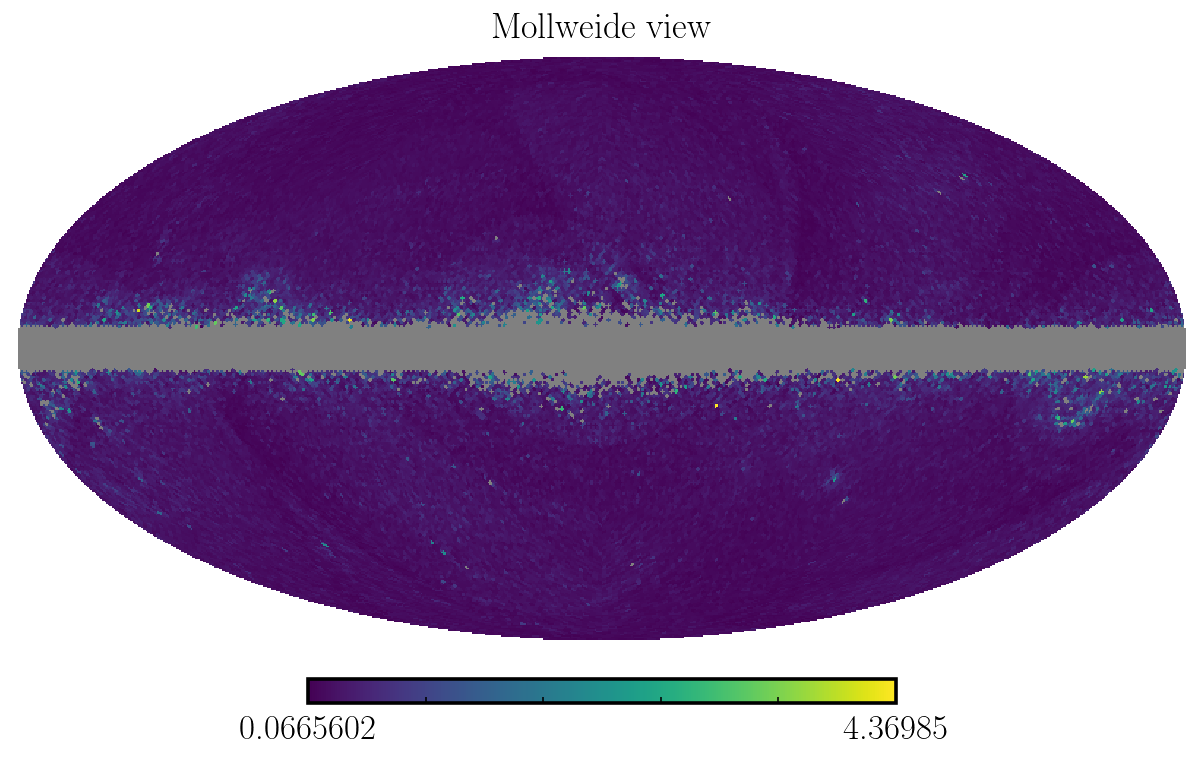

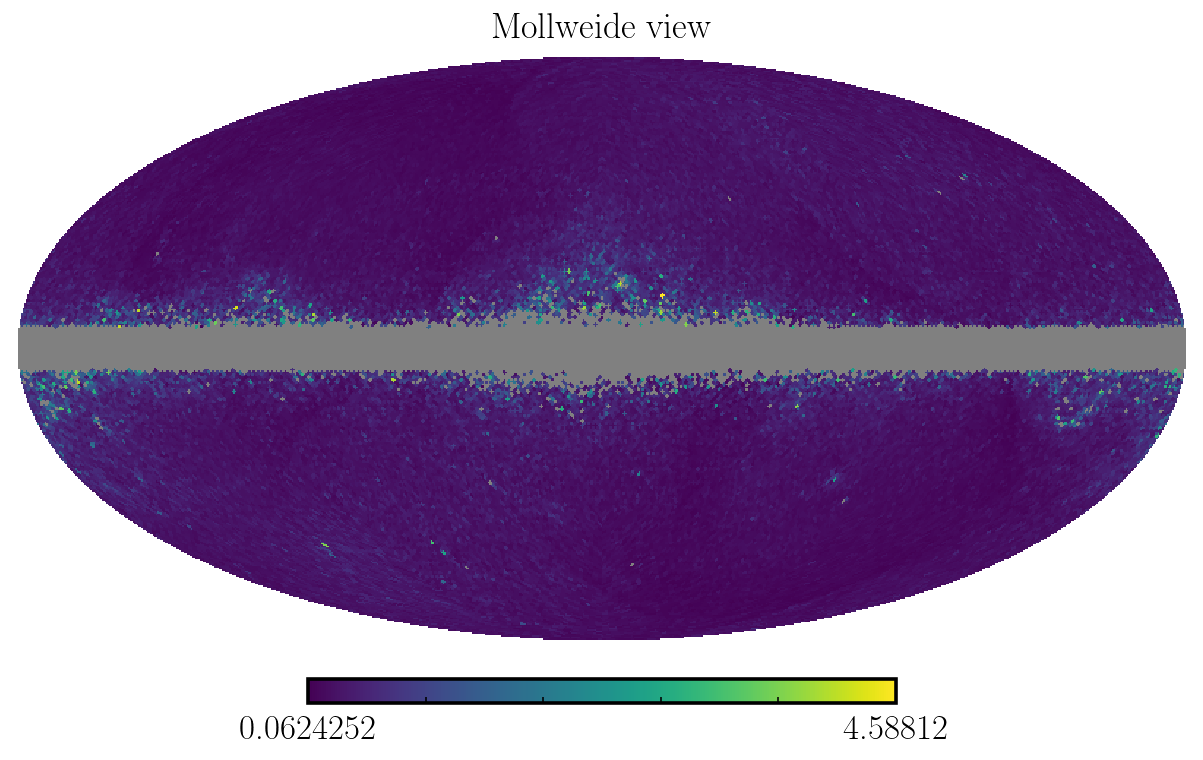

In [43]:
from tqdm.notebook import tqdm

In [70]:
def cat2hpx(lon, lat, nside, radec=True):
    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

def bin2hpx(lon, lat, qty, nside, radec=True):
    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix)
    
    
    for i in tqdm(idx):
        hpx_map[i] = np.mean(qty[indices == i])
        
    return hpx_map

In [129]:
n_qsrs_map = cat2hpx(coords_qsrs.l.value, coords_qsrs.b.value, nside=32, radec=False)
pmra_err_map = bin2hpx(coords_qsrs.l.value, coords_qsrs.b.value, pmra_err, nside=32, radec=False)
pmdec_err_map = bin2hpx(coords_qsrs.l.value, coords_qsrs.b.value, pmdec_err, nside=32, radec=False)

  0%|          | 0/11095 [00:00<?, ?it/s]

  0%|          | 0/11095 [00:00<?, ?it/s]

In [131]:
qsr_mask = n_qsrs_map == 0

In [146]:
sigma_noise_model.shape

(2, 12288)

In [152]:
np.mean(sigma_noise_model[:, ~qsr_mask], axis=1) 

array([0.17319488, 0.15604097])

In [154]:
sigma_noise_model.shape

(2, 12288)

In [230]:
sigma_noise_model.shape

(2, 12288)

In [219]:
sigma_noise_model = sigma_noise_model.T

In [220]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [221]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [222]:
sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1587 subhalos between 7.0 and 10.0


In [7]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [223]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
        x = x + sampled_noise
        return x 

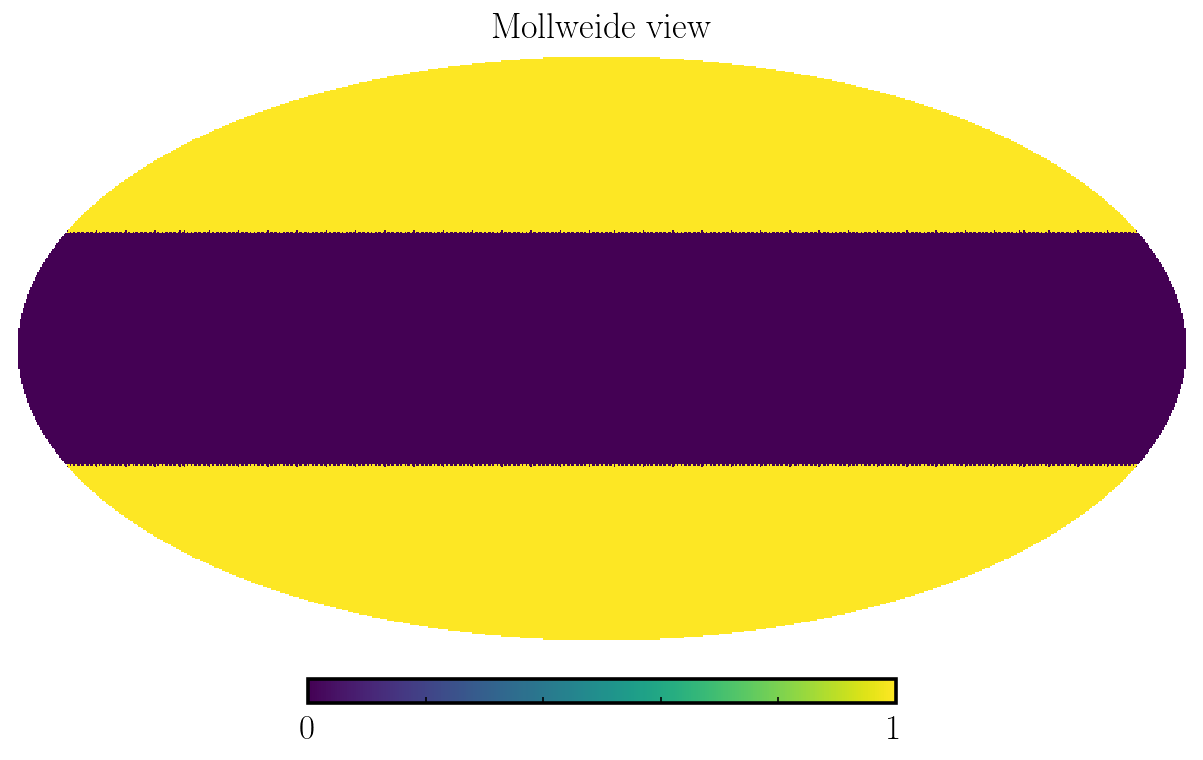

In [310]:
mask = ~cm.make_mask_total(band_mask=True, band_mask_range=30, nside=64)
hp.mollview(mask)

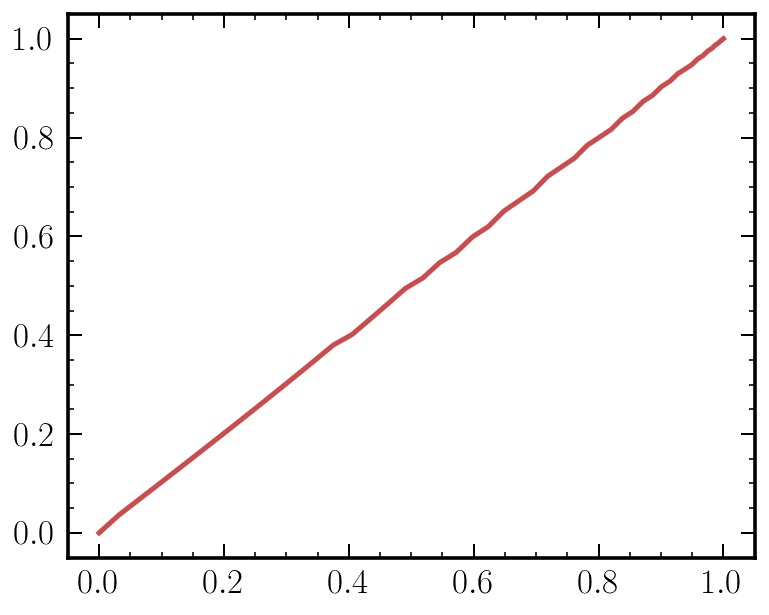

In [224]:
from simulation import create_mask as cm

f_sky = []
band_mask_list = np.linspace(0, 90)
for band_mask in band_mask_list:
    mask = ~cm.make_mask_total(band_mask=True, band_mask_range=band_mask, nside=64)
    f_sky.append(np.sum(~mask) / hp.nside2npix(64))
plt.plot((np.sin(np.deg2rad(band_mask_list))), f_sky)

In [248]:
x_test[1].std()

tensor(0.0030, dtype=torch.float64)

In [329]:
sigma_noise_model[0].mean() * 3/2

0.0021669921874999925

In [332]:
np.random.normal(scale=2 * np.ones(200)).std()

1.9570336031687567

In [341]:
sigma_noise_model[0][sigma_noise_model[0] > 0]

array([0.00160899, 0.00123067, 0.00168372, ..., 0.00108711, 0.00120115,
       0.00114699])

In [338]:
np.random.normal(scale=sigma_noise_model[0][sigma_noise_model[0] > 0]).std()

0.003218253642126744

In [411]:
n_qsrs_map[qsr_mask] = 1.

sigma_ra_qsrs = pmra_err_map / np.sqrt(n_qsrs_map)
sigma_dec_qsrs = pmdec_err_map / np.sqrt(n_qsrs_map)

sigma_noise_model = np.array([sigma_ra_qsrs, sigma_dec_qsrs])

np.save("../data/gaia_DR2_quasar_noise.npy", sigma_noise_model)

sigma_noise = 0.0036

sigma_noise_model[:, ~qsr_mask] /= np.sqrt(np.expand_dims(np.mean(sigma_noise_model[:, ~qsr_mask] ** 2, axis=1), axis=1) / sigma_noise ** 2)
sigma_noise_model = hp.ud_grade(sigma_noise_model, nside_out=64, power=0)

np.random.normal(scale=sigma_noise_model[0][sigma_noise_model[0] > 0]).std()

0.003485489686081743

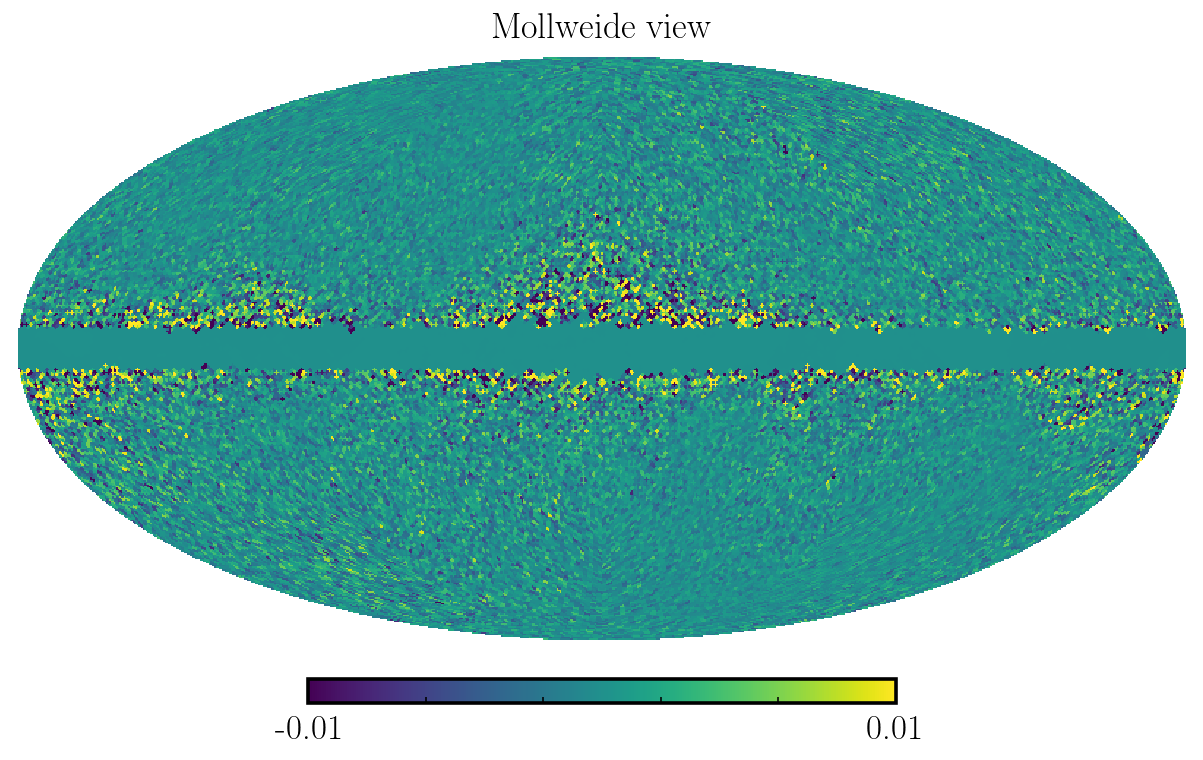

In [412]:
mask = torch.Tensor(~cm.make_mask_total(band_mask=True, band_mask_range=20, nside=64))
x_test = (torch.Tensor(sim.mu_qsrs.T)).T

# Add noise
gn = GaussianNoiseAnisotropic(sigma=sigma_noise_model)
x_test = gn(x_test.T)

hp.mollview(x_test[0], min=-0.01, max=0.01)

In [413]:
x_test[0, sigma_noise_model[0] > 0].std()

tensor(0.0036, dtype=torch.float64)

In [414]:
x_test[0, sigma_noise_model[0] * mask.numpy() > 0].std()

tensor(0.0021, dtype=torch.float64)

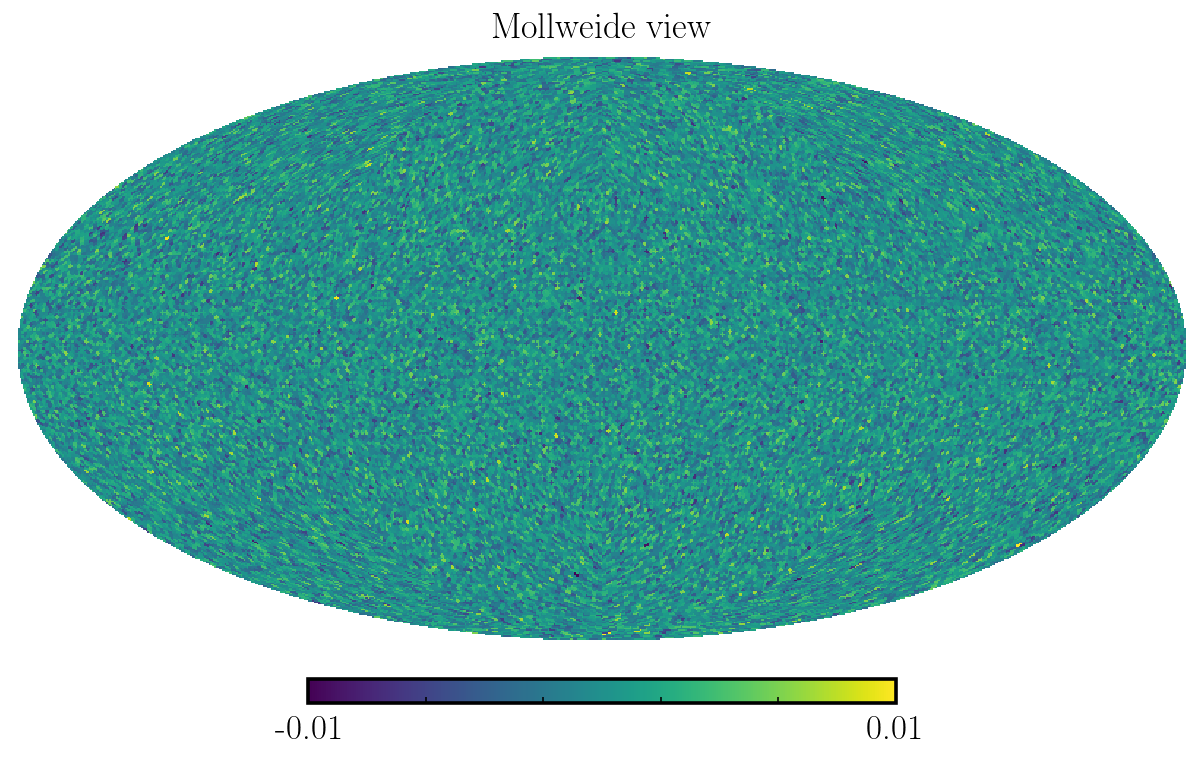

In [399]:
x_test = torch.Tensor(sim.mu_qsrs)

# Add noise
gn = GaussianNoise(sigma=0.0023)
x_test = gn(x_test).T

hp.mollview(x_test[0], min=-0.01, max=0.01)

In [1]:
n_trials = 1  # Number of samples to simulate
n_test = 1  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    # Simulate subhalos and make astrometric map
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    # Add noise
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
    theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

    # Compute LLR over the parameter grid
    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test[i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

NameError: name 'np' is not defined